In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist


customers_file = r"C:\Users\rahul\Downloads\Data_Science\Customers.csv"
transactions_file = r"C:\Users\rahul\Downloads\Data_Science\Transactions.csv"


customers_df = pd.read_csv(customers_file)
transactions_df = pd.read_csv(transactions_file)


print("Customer DataFrame Columns:")
print(customers_df.columns.tolist())
print("\nTransaction DataFrame Columns:")
print(transactions_df.columns.tolist())


print("\nFirst few rows of Customers data:")
display(customers_df.head())
print("\nFirst few rows of Transactions data:")
display(transactions_df.head())


Customer DataFrame Columns:
['CustomerID', 'CustomerName', 'Region', 'SignupDate']

Transaction DataFrame Columns:
['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price']

First few rows of Customers data:


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15



First few rows of Transactions data:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


Loading and preprocessing data...

Finding optimal number of clusters...


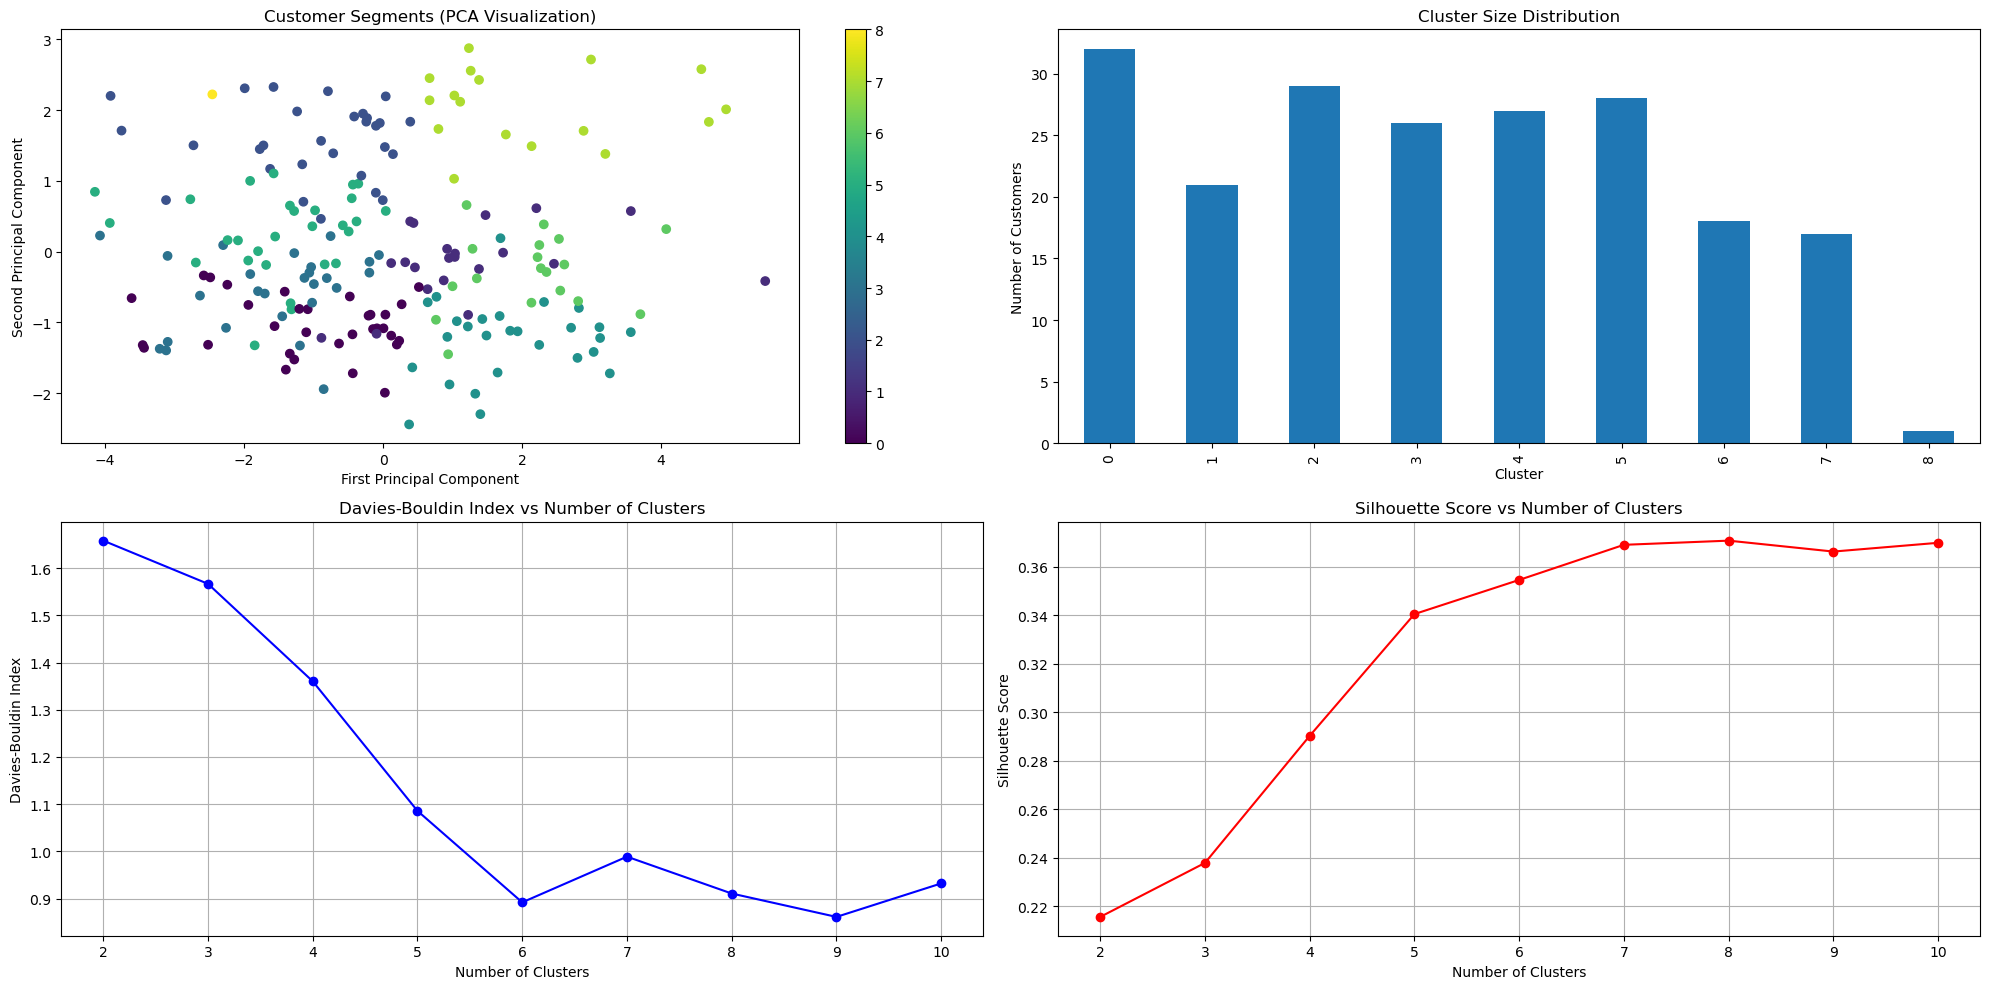


CLUSTERING RESULTS REPORT
Number of clusters formed: 9
DB Index value: 0.8611

Other Clustering Metrics:
Silhouette Score: 0.3662
Calinski-Harabasz Score: 64.3758

Cluster Profiles:
   Cluster_Size  Avg_Transactions  Avg_Total_Spent  Avg_Transaction_Value
0            32              3.88          2394.77                 604.26
1            21              6.05          5075.26                 863.81
2            29              3.79          2484.23                 659.19
3            26              3.19          2124.87                 691.65
4            27              6.67          5285.92                 814.93
5            28              3.75          2097.94                 578.90
6            18              7.50          5379.35                 736.29
7            17              7.88          4721.81                 607.15
8             1              2.00           931.83                 465.92


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist


customers_file = r"C:\Users\rahul\Downloads\Data_Science\Customers.csv"
transactions_file = r"C:\Users\rahul\Downloads\Data_Science\Transactions.csv"

def preprocess_data(customers_file, transactions_file):
    """
    Load and preprocess customer and transaction data
    """

    customers_df = pd.read_csv(customers_file)
    transactions_df = pd.read_csv(transactions_file)
    

    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    

    trans_agg = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'Quantity': ['sum', 'mean'],  # Total and average quantity
        'TotalValue': ['sum', 'mean'],  # Total and average value
        'Price': 'mean',  # Average price of products bought
        'ProductID': 'nunique',  # Number of unique products
        'TransactionDate': ['min', 'max']  # First and last transaction dates
    }).reset_index()
    

    trans_agg.columns = ['CustomerID', 'num_transactions', 'total_quantity', 
                        'avg_quantity', 'total_spent', 'avg_transaction_value',
                        'avg_price', 'unique_products', 'first_transaction', 
                        'last_transaction']
    

    trans_agg['customer_lifetime_days'] = (pd.to_datetime(trans_agg['last_transaction']) - 
                                         pd.to_datetime(trans_agg['first_transaction'])).dt.days
    trans_agg['purchase_frequency'] = trans_agg['num_transactions'] / trans_agg['customer_lifetime_days']
    

    trans_agg = trans_agg.replace([np.inf, -np.inf], np.nan)
    trans_agg = trans_agg.fillna(0)
    

    customers_df = pd.get_dummies(customers_df, columns=['Region'])
    

    final_df = customers_df.merge(trans_agg, on='CustomerID', how='inner')
    

    features_for_clustering = ['total_quantity', 'total_spent', 'avg_transaction_value',
                             'num_transactions', 'unique_products', 'purchase_frequency'] + \
                             [col for col in final_df.columns if col.startswith('Region_')]
    
    return final_df[features_for_clustering], final_df

def calculate_db_index(X, labels, centroids):
    """Calculate Davies-Bouldin Index"""
    n_clusters = len(np.unique(labels))
    cluster_k = [X[labels == k] for k in range(n_clusters)]
    cent_k = centroids
    
    s_k = [np.mean([np.linalg.norm(p - cent_k[i]) for p in cluster_k[i]])
           if len(cluster_k[i]) > 0 else 0
           for i in range(n_clusters)]
    
    R = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                R[i,j] = ((s_k[i] + s_k[j]) / 
                         (np.linalg.norm(cent_k[i] - cent_k[j])))
    
    return np.mean([np.max([R[i,j] for j in range(n_clusters) if i != j])
                   for i in range(n_clusters)])

def find_optimal_clusters(X_scaled, range_n_clusters):
    """Find optimal number of clusters using multiple metrics"""
    results = []
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        
        results.append({
            'n_clusters': n_clusters,
            'db_index': calculate_db_index(X_scaled, labels, kmeans.cluster_centers_),
            'silhouette': silhouette_score(X_scaled, labels),
            'calinski_harabasz': calinski_harabasz_score(X_scaled, labels)
        })
    
    return pd.DataFrame(results)

def plot_clustering_results(X_scaled, labels, metrics_df):
    """Create visualizations for clustering results"""
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 10))
    

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title('Customer Segments (PCA Visualization)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    

    plt.subplot(2, 2, 2)
    pd.Series(labels).value_counts().sort_index().plot(kind='bar')
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    
 
    plt.subplot(2, 2, 3)
    plt.plot(metrics_df['n_clusters'], metrics_df['db_index'], 'bo-')
    plt.title('Davies-Bouldin Index vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.grid(True)
    

    plt.subplot(2, 2, 4)
    plt.plot(metrics_df['n_clusters'], metrics_df['silhouette'], 'ro-')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print("Loading and preprocessing data...")
features_df, full_df = preprocess_data(customers_file, transactions_file)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)


print("\nFinding optimal number of clusters...")
range_n_clusters = range(2, 11)
metrics_df = find_optimal_clusters(X_scaled, range_n_clusters)


optimal_n_clusters = metrics_df.loc[metrics_df['db_index'].idxmin(), 'n_clusters']


final_kmeans = KMeans(n_clusters=int(optimal_n_clusters), random_state=42)
labels = final_kmeans.fit_predict(X_scaled)

# Plot results
plot_clustering_results(X_scaled, labels, metrics_df)


print("\nCLUSTERING RESULTS REPORT")
print("=" * 50)
print(f"Number of clusters formed: {int(optimal_n_clusters)}")
print(f"DB Index value: {metrics_df.loc[metrics_df['n_clusters'] == optimal_n_clusters, 'db_index'].values[0]:.4f}")
print("\nOther Clustering Metrics:")
print(f"Silhouette Score: {metrics_df.loc[metrics_df['n_clusters'] == optimal_n_clusters, 'silhouette'].values[0]:.4f}")
print(f"Calinski-Harabasz Score: {metrics_df.loc[metrics_df['n_clusters'] == optimal_n_clusters, 'calinski_harabasz'].values[0]:.4f}")


cluster_profiles = pd.DataFrame({
    'Cluster_Size': pd.Series(labels).value_counts().sort_index(),
    'Avg_Transactions': pd.Series([features_df.iloc[labels == i]['num_transactions'].mean() for i in range(int(optimal_n_clusters))]),
    'Avg_Total_Spent': pd.Series([features_df.iloc[labels == i]['total_spent'].mean() for i in range(int(optimal_n_clusters))]),
    'Avg_Transaction_Value': pd.Series([features_df.iloc[labels == i]['avg_transaction_value'].mean() for i in range(int(optimal_n_clusters))])
})

print("\nCluster Profiles:")
print("=" * 50)
print(cluster_profiles.round(2))